Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# Models

Model analysis experiments, for example parameter statistics and Fisher information.

In [ ]:
%load_ext autoreload
%autoreload 2

import collections
import math
import numpy as np
import re
import scipy.stats
import tqdm
import torch
from torch import tensor, Tensor
import transformers
from typing import Iterable, Any

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import weight_formats.analysis as A
import weight_formats.experiments as E
import weight_formats.fit as F
import weight_formats.quantisation as Q
import plot_utils

transformers.utils.logging.disable_progress_bar()
plot_utils.configure()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


### `ma_parameter_hist`

In [2]:
weight_stats = {run.config.model.split("/")[1]: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}

bins = torch.arange(1, 20 + 1)
xs = torch.cat([bins, torch.tensor([21])]) - 0.5
n_samples = 2**27
studentt_df = 7

dist_data = {name: E.weight_stats.scaled_hist(t, bins, dim=None) for name, t in {
    "Normal": torch.randn(n_samples),
    "Laplace": torch.distributions.Laplace(0., 1.).sample((n_samples,)),
    f"t[$\\nu={studentt_df}$]": torch.distributions.StudentT(studentt_df).sample((n_samples,)),
}.items()}

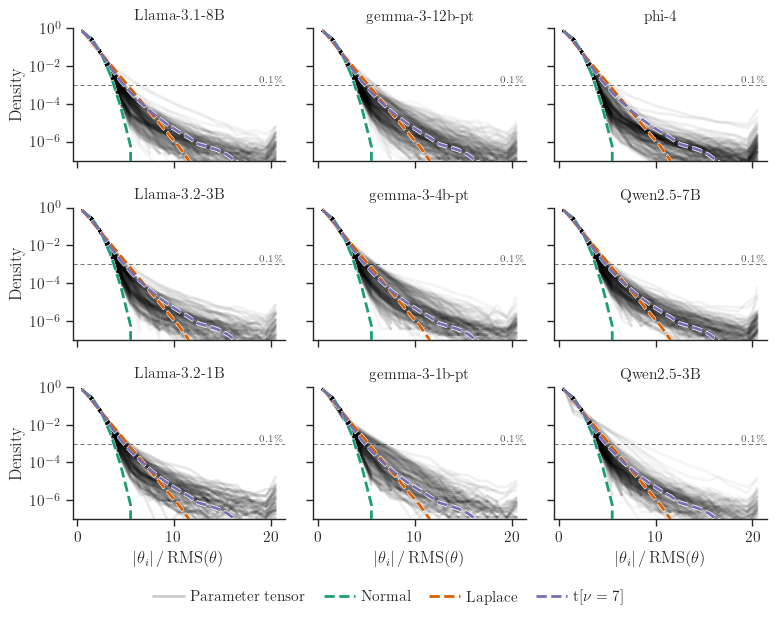

In [7]:
figw, figh = matplotlib.rcParams["figure.figsize"]
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(figw, 2. * figh), sharey=True, sharex=True)

param_line = dict(color="k", lw=2, label="Parameter tensor")
dist_lines = [
    (name, dict(label=name, lw=2, ls="--", color=color))
    for name, color in zip(dist_data, plot_utils.PALETTE)
]

for model, ax in zip(plot_utils.MODEL_ORDER_GRID, axs.flatten()):
    for p in weight_stats[model].values():
        if len(p["shape"]) == 2:
            hist = tensor(p["hist"])
            ax.plot(xs, torch.where(hist==0, torch.nan, hist), **param_line, alpha=10/len(weight_stats[model]), zorder=1)
    for dist, args in dist_lines:
        ax.plot(xs, dist_data[dist]*1.1, zorder=100, **{**args, "color": "w"})  # hack an embossing effect to make the line easier to see
        ax.plot(xs, dist_data[dist]/1.1, zorder=100, **{**args, "color": "w"})
        ax.plot(xs, dist_data[dist], zorder=101, **args)
    ax.set_title(model)
    ax.axhline(10**-3, color="#444", lw=0.5, dashes=(6, 4), zorder=0)
    ax.annotate(r"$0.1\%$", (20, 10**-3), ha="center", va="bottom", fontsize=7, color="#444")

for ax in axs[:, 0]:
    ax.set_yscale("log")
    ax.set_ylim((10**-7, 1))
    ticks = [-6, -4, -2, 0]
    ax.set_yticks([10**t for t in ticks], [f"$10^{{{t}}}$" for t in ticks])
    ax.set_ylabel("Density", fontsize=12)

for ax in axs[-1, :]:
    ax.set_xlabel(r"$|\theta_{i}| \,/\, \mathrm{RMS}(\theta)$", fontsize=12)

plot_utils.set_figure_legend(axs[0, 0].figure, build=[dict(**param_line, alpha=.2), *dist_lines],
    bbox_to_anchor=(0.0, 0.02, 1.0, 0), loc="upper center", ncols=4, columnspacing=1.25, handletextpad=0.4)
plot_utils.tidy(axs[0, 0].figure)
plot_utils.save("ma_parameter_hist")

### `ma_kl_fisher_prediction_noise`, `ma_kl_fisher_prediction_noise_grid`

In [2]:
fisher_sum = {run.config.model.split("/")[1]: run.summary.fisher for run in E.runs("20250604-fisher")}
weight_stats = {run.config.model.split("/")[1]: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}
runs = E.runs("20250502-noise-sensitivity")

In [18]:
def get_row(run: E.AttrDict) -> dict[str, Any]:
    if run.meta.status == "finished" and "vision_model" not in run.config.test.parameter and "multi_modal_projector" not in run.config.test.parameter:
        model = run.config.model.split("/")[1]
        return dict(
            model=model,
            scale=run.config.test.scale,
            parameter=run.config.test.parameter,
            fisher_sum=fisher_sum[model][run.config.test.parameter],
            rm2=weight_stats[model][run.config.test.parameter].rm2,
            nelem=math.prod(weight_stats[model][run.config.test.parameter].shape),
            kl_div=tensor(run.summary.kl_div).mean().item(),
        )

df = pd.DataFrame.from_records(filter(None, map(get_row, runs)))
df["kl_div_prediction"] = 0.5 * (df.scale * df.rm2) ** 2 * df.fisher_sum
df["magnitude_prediction"] = 0.5 * (df.scale * df.rm2) ** 2 * df.nelem
df["kl_div_prediction_error_ratio"] = df.kl_div_prediction / df.kl_div
df.head()

,model,scale,parameter,fisher_sum,rm2,nelem,kl_div,kl_div_prediction,magnitude_prediction,kl_div_prediction_error_ratio
0,Llama-3.2-1B,0.25,model.embed_tokens.weight,7024.509300,0.021907,262668288.0,0.100927,0.105347,3939.266417,1.043799
1,Llama-3.2-1B,0.25,model.layers.0.self_attn.q_proj.weight,7.519005,0.036875,4194304.0,0.001434,0.000320,178.227007,0.222791
2,Llama-3.2-1B,0.25,model.layers.0.self_attn.k_proj.weight,11.987835,0.047735,1048576.0,0.002423,0.000854,74.664832,0.352253
3,Llama-3.2-1B,0.25,model.layers.0.self_attn.v_proj.weight,1270.149700,0.009144,1048576.0,0.006154,0.003319,2.739743,0.539305
4,Llama-3.2-1B,0.25,model.layers.0.self_attn.o_proj.weight,738.456300,0.011592,4194304.0,0.005260,0.003101,17.611697,0.589463


remote: Updating references: 100% (1/1)           


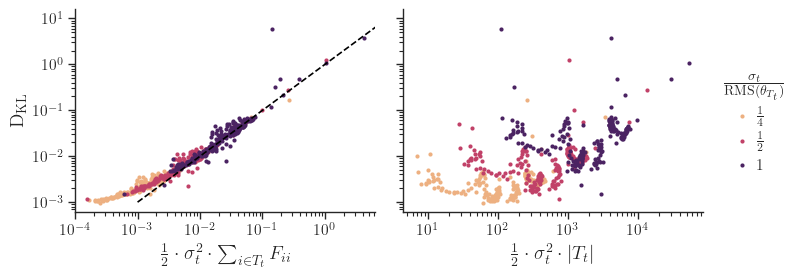

In [14]:
kl_fisher_prediction_legend_title = r"$\frac{\sigma_t}{\text{RMS}(\theta_{T_t})}$"
scales = [
    (s, dict(marker="o", lw=0, color=color, label=plot_utils.format_fraction()(s, None)))
    for s, color in zip(sorted(df.scale.unique()), plot_utils.SEQ_PALETTE(matplotlib.colors.LogNorm()(df.scale.unique())))
]
def kl_fisher_prediction(model: str, predictor: str, ax: matplotlib.axes.Axes) -> None:
    for scale, args in scales:
        d = df[(df.model == model) & (df.scale == scale)]
        ax.scatter(d[predictor], d.kl_div, **args)
    if predictor == "kl_div_prediction":
        ax.plot([10**-3, 10], [10**-3, 10], "k--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    if predictor == "kl_div_prediction":
        ax.set_xlabel(r"$\frac{1}{2} \cdot \sigma_t^2 \cdot \sum_{i \in T_t} F_{ii}$")
        ax.set_xlim((10**-4, 10**0.8))
    if predictor == "magnitude_prediction":
        ax.set_xlabel(r"$\frac{1}{2} \cdot \sigma_t^2 \cdot |T_t|$")
    ax.set_ylabel(r"$\kl$")

model = "Llama-3.1-8B"
fig, axs = plt.subplots(ncols=2, sharey=True)
for ax, predictor in zip(axs, ["kl_div_prediction", "magnitude_prediction"]):
    kl_fisher_prediction(model, predictor, ax)
axs[1].set_ylabel("")
plot_utils.set_figure_legend(axs[0].figure, *axs[0].get_legend_handles_labels(), title=kl_fisher_prediction_legend_title, handletextpad=1, handlelength=0)
plot_utils.tidy(fig)
plot_utils.save("ma_kl_fisher_prediction_noise")

remote: Updating references: 100% (1/1)           


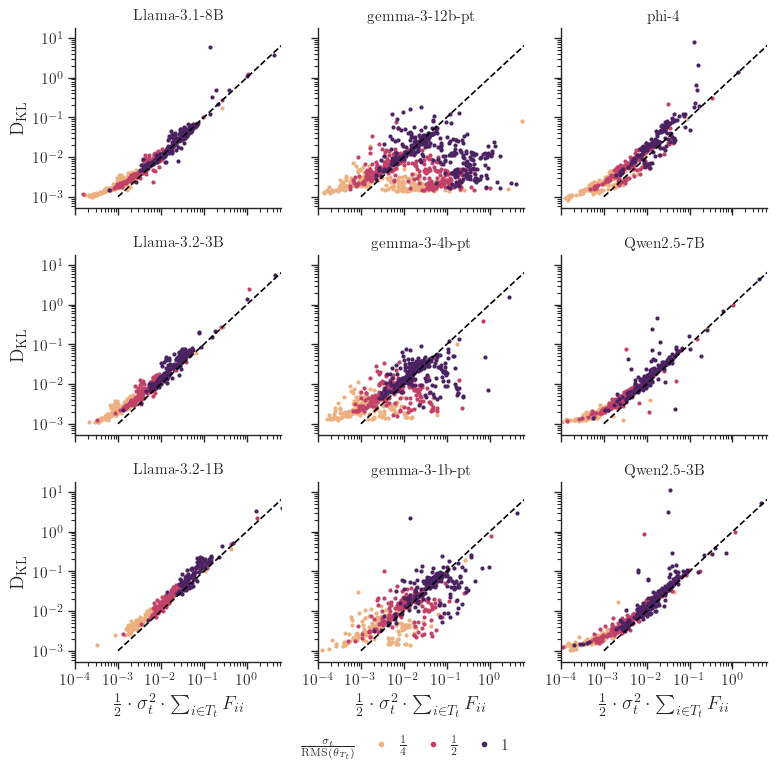

In [16]:
figw, figh = matplotlib.rcParams["figure.figsize"]
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(figw, 2.5 * figh), sharey=True, sharex=True)

for model, ax in zip(plot_utils.MODEL_ORDER_GRID, axs.flatten()):
    build = kl_fisher_prediction(model, "kl_div_prediction", ax)
    ax.set_title(model)

for ax in axs[:-1, :].flatten():
    ax.set_xlabel("")

for ax in axs[:, 1:].flatten():
    ax.set_ylabel("")

plot_utils.set_figure_legend(axs[0, 0].figure, build=[kl_fisher_prediction_legend_title, *scales],
    bbox_to_anchor=(0.0, 0.02, 1.0, 0), loc="upper center", ncols=4, columnspacing=0.75, handletextpad=0.2)
plot_utils.tidy(axs[0, 0].figure)
plot_utils.save("ma_kl_fisher_prediction_noise_grid")

In [ ]:
display(df.pipe(lambda d: d[(d.model == "gemma-3-12b-pt") & (d.scale == 0.25)])
        .pipe(lambda d: d.assign(parameter_short=d.parameter.apply(lambda s: s.replace("language_model.model.", ""))))
        .sort_values("kl_div_prediction_error_ratio", ascending=False)
        [:10][["parameter_short", "kl_div", "kl_div_prediction", "kl_div_prediction_error_ratio"]])

,parameter_short,kl_div,kl_div_prediction,kl_div_prediction_error_ratio
5126,layers.0.self_attn.k_proj.weight,0.001531,2.757030,1800.392102
5266,layers.2.self_attn.q_proj.weight,0.001489,0.258825,173.825408
5277,layers.2.self_attn.k_proj.weight,0.001462,0.202290,138.324372
5116,layers.0.self_attn.q_proj.weight,0.001415,0.110423,78.029900
5105,embed_tokens.weight,0.079759,5.823125,73.008669
5426,layers.4.self_attn.k_proj.weight,0.001443,0.093317,64.669239
5180,layers.0.mlp.down_proj.weight,0.002179,0.110943,50.914780
5565,layers.6.self_attn.q_proj.weight,0.001469,0.053731,36.576491
5533,layers.5.mlp.gate_proj.weight,0.001903,0.069227,36.377594
5415,layers.4.self_attn.q_proj.weight,0.001419,0.051307,36.168319


### `ma_fisher_structure`

Analysis of structure in the diagonal Fisher, to justify the constant-per-tensor approximation

In [18]:
# Warning: this can take ~2m
fisher = E.fisher.fetch_fisher("meta-llama/Llama-3.1-8B", device=DEVICE)

remote: Updating references: 100% (1/1)           


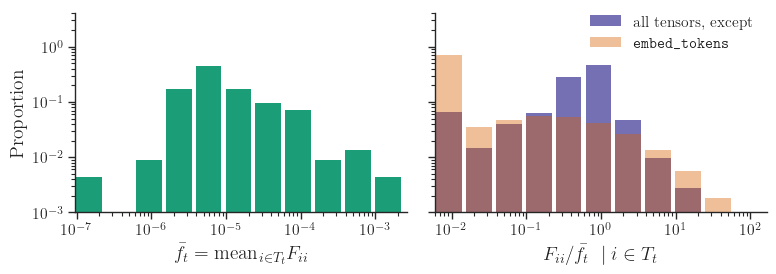

In [21]:
def count_histogram(tensors: Iterable[Tensor], bins: Tensor) -> Tensor:
    boundaries = (bins[1:] + bins[:-1]) / 2
    counts = torch.zeros(len(bins), dtype=torch.int64, device=DEVICE)
    for t in tensors:
        counts += torch.bincount(torch.bucketize(t, boundaries), minlength=len(bins))
    return counts

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
last_bin_ratio = 0.6  # make sure we clip the last bin, since the bin edges are open
width_ratio = 0.5  # hack
xrange = 4
xstep = 0.4

x0 = -6.8
bins = 10 ** torch.arange(x0, x0 + xrange + 1e-3, xstep, device=DEVICE)
binw = torch.diff(torch.cat([bins, bins[-1:] ** 2 / bins[-2]])).cpu() * width_ratio
counts = count_histogram([torch.stack([t.mean(dtype=torch.float32) for t in fisher.values()])], bins)
counts = counts / counts.sum()
ax0.bar(bins.cpu(), counts.cpu(), width=binw, lw=0, color=plot_utils.PALETTE[0])

ax0.set_xscale("log")
ax0.set_xlabel(r"$\bar{f}_t = \mathrm{mean}_{i \in T_t} F_{ii}$")
ax0.set_xlim((bins[0].item() * last_bin_ratio, bins[-1].item() / last_bin_ratio))

bins = 10 ** torch.arange(-xrange/2, xrange/2 + 1e-3, xstep, device=DEVICE)
binw = torch.diff(torch.cat([bins, bins[-1:] ** 2 / bins[-2]])).cpu() * width_ratio
counts = count_histogram((fisher[k].flatten().float() / fisher[k].mean(dtype=torch.float32) for k in fisher if k != "model.embed_tokens.weight"), bins)
counts = counts / counts.sum()
ax1.bar(bins.cpu(), counts.cpu(), width=binw, label="all tensors, except", lw=0, color=plot_utils.PALETTE[2])
counts = count_histogram((fisher[k].flatten().float() / fisher[k].mean(dtype=torch.float32) for k in ["model.embed_tokens.weight"]), bins)
counts = counts / counts.sum()
ax1.bar(bins.cpu(), counts.cpu(), width=binw, lw=0, alpha=.4, label=r"\texttt{embed_tokens}", color=plot_utils.PALETTE[1])

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim((bins[0].item() * last_bin_ratio, bins[-1].item() / last_bin_ratio))
ax1.set_xlabel(r"$F_{ii} / \bar{f}_t \;\mid i \in T_t$")
ax1.legend(loc="upper right", bbox_to_anchor=(1, 1.06))

ax0.set_ylim((10**-3, 4))
ax0.set_ylabel("Proportion")

plot_utils.tidy(fig)
plot_utils.save("ma_fisher_structure")

In [20]:
display(pd.DataFrame.from_dict([dict(tensor=k, fisher_mean=v.mean(dtype=torch.float32).item()) for k, v in fisher.items()]).sort_values("fisher_mean"))

,tensor,fisher_mean
7,model.layers.0.self_attn.q_proj.weight,2.031723e-07
5,model.layers.0.self_attn.k_proj.weight,1.590264e-06
119,model.layers.23.self_attn.q_proj.weight,1.719210e-06
126,model.layers.24.self_attn.q_proj.weight,1.944991e-06
175,model.layers.30.self_attn.q_proj.weight,2.101389e-06
...,...,...
169,model.layers.3.self_attn.v_proj.weight,4.142772e-04
92,model.layers.2.self_attn.v_proj.weight,5.397277e-04
15,model.layers.1.self_attn.v_proj.weight,9.105785e-04
9,model.layers.1.mlp.down_proj.weight,1.001650e-03


In [21]:
del fisher  # memory!

### `tab:bit_count_contributors`

In [2]:
model = "meta-llama/Llama-3.1-8B"
fisher_sum = E.fisher.fetch_fisher_sum(model, experiment_name="20250423-fisher")
weight_stats = E.weight_stats.fetch_weight_stats(model, experiment_name="20250423-weight-stats")
nelement = {k: math.prod(v.shape) for k, v in weight_stats.items()}
run = E.run("20250503-llama8b-refresh/rtaLm8kbgd")
assert run.config.model == model
print(run.config.test.fmt_str, f"KL: {tensor(run.summary.kl_div).mean():.3f}")

def dist_stats(t: Tensor) -> Tensor:
    a, b = t.quantile(tensor([0.1, 0.9]))
    return dict(std=t.std().item(), range9010=(b - a).item())

fisher = tensor([fisher_sum[k] / nelement[k] for k in weight_stats])
rms = tensor([weight_stats[k].rm2 for k in weight_stats])
epsilon = tensor([run.summary.params[k].rmse / weight_stats[k].rm2 / 2**-run.summary.bits_per_param for k in weight_stats])

df = pd.DataFrame.from_records([
    dict(term="Fisher", label=r"$\frac{1}{2} \log_2 \bar{f}_t$", **dist_stats(0.5 * fisher.log2())),
    dict(term="RMS", label=r"$\log_2 \hat{\sigma}_t$", **dist_stats(rms.log2())),
    dict(term="Epsilon", label=r"$\log_2 \epsilon_t$", **dist_stats(epsilon.log2())),
])
display(df)

4b-lloyd_max{1,64:BFLOAT16:absmax} KL: 0.111


,term,label,std,range9010
0,Fisher,$\frac{1}{2} \log_2 \bar{f}_t$,0.880111,2.037272
1,RMS,$\log_2 \hat{\sigma}_t$,0.464957,1.333252
2,Epsilon,$\log_2 \epsilon_t$,0.030227,0.064262


In [12]:
plot_utils.save_table("bit_count_contributors", df, dict(label="", std="std", range9010=r"$\mathrm{q}_{90\%}-\mathrm{q}_{10\%}$"))

remote: Updating references: 100% (1/1)           


In [248]:
# runs = E.runs("20250503-llama8b-refresh")
# df = pd.DataFrame.from_records(
#     dist_stats(tensor([run.summary.params[k].rmse / weight_stats[k].rm2 / 2**-run.summary.bits_per_param for k in weight_stats]).log2())
#     for run in runs
#     if run.meta.status == "finished"
# )
# _, ax = plt.subplots()
# bins = torch.linspace(0, 2, 21)
# sns.histplot(data=df, x="std", label="std", bins=bins, ax=ax)
# sns.histplot(data=df, x="range9010", label="range-90-10", bins=bins, ax=ax)
# ax.set_xlabel("Value")
# ax.legend()

### `ma_fisher_bit_allocation`

In [17]:
model = "meta-llama/Llama-3.1-8B"
average_bits_target = 4

fisher_sum = E.fisher.fetch_fisher_sum(model, experiment_name="20250423-fisher")
weight_stats = E.weight_stats.fetch_weight_stats(model, experiment_name="20250423-weight-stats")
nelement = {k: math.prod(v.shape) for k, v in weight_stats.items()}

bit_delta = {k: math.log2(weight_stats[k].rm2) + 0.5 * math.log2(fisher_sum[k] / nelement[k]) for k in fisher_sum}
bit_offset = average_bits_target - sum(bit_delta[k] * nelement[k] for k in fisher_sum) / sum(nelement.values())
bits = {k: max(2, bit_offset + bit_delta[k]) for k in fisher_sum}
average_bits = sum(bits[k] * nelement[k] for k in bits) / sum(nelement.values())

df = pd.DataFrame.from_records(dict(parameter=k, bits=b) for k, b in bits.items())
df["type"] = df.parameter.apply(lambda s: s.split(".")[-2])
df["layer"] = df.parameter.apply(lambda s: int(re.search(r"(\d+)", s).group()) if re.search(r"(\d+)", s) else None)

remote: Updating references: 100% (1/1)           


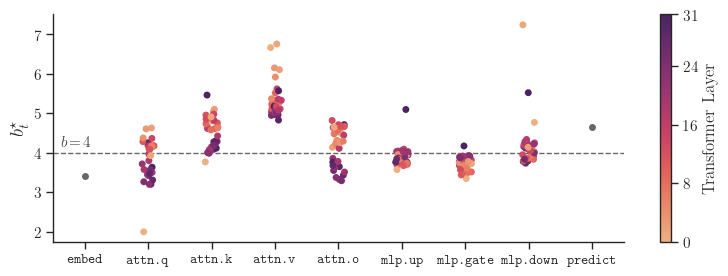

In [19]:
types = dict(embed_tokens="embed", q_proj="attn.q", k_proj="attn.k", v_proj="attn.v", o_proj="attn.o",
             up_proj="mlp.up", gate_proj="mlp.gate", down_proj="mlp.down", lm_head="predict")

_, ax = plt.subplots()
sns.stripplot(data=df, y="bits", x="type", order=types, hue="layer", palette=plot_utils.SEQ_PALETTE, ax=ax)
sns.stripplot(data=df[df.layer.isna()], y="bits", x="type", order=types, ax=ax, color="#666")
ax.axhline(average_bits, color="#666", lw=1, ls="--")
ax.annotate(r"$b\!=\!4$", [0, average_bits], (-17, 5), textcoords="offset points", color="#444", fontsize=11)

ax.set_xticks(range(len(types)))
ax.set_xticklabels([f"\\texttt{{{types[label.get_text()]}}}" for label in ax.get_xticklabels()], fontsize=10)
ax.set_ylabel(r"$b_t^{\star}$")
ax.set_xlabel("")

ax.legend_.remove()
sm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, df.layer.max()), cmap=plot_utils.SEQ_PALETTE)
cbar = ax.figure.colorbar(sm, ax=ax)
cbar.set_label("Transformer Layer", fontsize=12)
cbar.set_ticks([0, 8, 16, 24, 31])

plot_utils.tidy(ax.figure)
plot_utils.save("ma_fisher_bit_allocation")

### `ma_empirical_fisher`

In [20]:
model = "meta-llama/Llama-3.1-8B"
fisher = E.fisher.fetch_fisher_sum(model, "20250423-fisher")
empirical_fisher = E.fisher.fetch_fisher_sum(model, "20250505-empirical-fisher")
nelement = {k: math.prod(v.shape) for k, v in E.weight_stats.fetch_weight_stats(model, "20250423-weight-stats").items()}

dropping 84481de49a399ddb76b5c2bf2775c9ac50bcffed Update figures -- patch contents already upstream
remote: Updating references: 100% (1/1)           


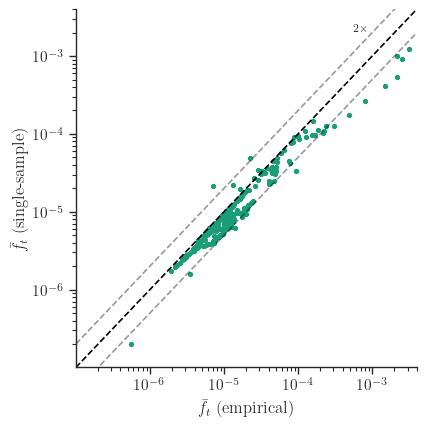

In [24]:
_, ax = plt.subplots(figsize=(4.5, 4.5))
ax.scatter([empirical_fisher[k] / nelement[k] for k in empirical_fisher],
           [fisher[k] / nelement[k] for k in empirical_fisher])
ax.set_xscale("log")
ax.set_yscale("log")
xs = tensor([1e-7, 4e-3])
ax.plot(xs, xs, "k--")
ax.plot(xs, 2 * xs, "k--", alpha=.4)
ax.plot(xs, xs / 2, "k--", alpha=.4)
ax.annotate(r"$2\times$", [10**-3, 2*10**-3], ha="right", va="bottom", fontsize=8, xytext=(-3, 0), textcoords="offset points")
ax.set_xlim(xs)
ax.set_ylim(xs)
ax.set_xlabel(r"$\bar{f}_t$ (empirical)", fontsize=12)
ax.set_ylabel(r"$\bar{f}_t$ (single-sample)", fontsize=12)

plot_utils.tidy(ax.figure)
plot_utils.save("ma_empirical_fisher")

### `ma_element_bit_histogram`

In [ ]:
def sketch_bits(fmt: Q.TensorFormat, p: Tensor) -> Tensor:
    """Generate a map, the same shape as `p` of the rough bits/value.

    Note: incomplete implementation.
    """

    if isinstance(fmt, Q.ScaledFormat):
        return sketch_bits(fmt.format, p / fmt.scale)

    if isinstance(fmt, Q.ScalarFormat):
        return torch.full(p.shape, fmt.bits, dtype=torch.float32, device=p.device)

    if isinstance(fmt, Q.SparseFormat):
        p, idx, val = Q.SparseFormat.split(p, fmt.sparse_ratio)
        s = sketch_bits(fmt.format, p)
        s.flatten()[idx] += sketch_bits(fmt.sparse_format, val) + 32  # values + mask
        return s

    if isinstance(fmt, Q.LinearScalingFormat):
        assert isinstance(fmt.scale_format, Q.ScalarFormat)
        p, _ = Q.block_normalise(p, fmt.block_shape, fmt.scaling, fmt.element_format.range, fmt.scale_format)
        if fmt.scaling == "rms":
            scale_nelement = math.prod(
                1 if bi is None else si // bi for si, bi in zip(p.shape, fmt.block_shape)
            )
            return sketch_bits(fmt.element_format, p) + fmt.scale_format.bits * scale_nelement / p.nelement()
        else:
            assert len(fmt.block_shape) == 2 and fmt.block_shape[0] == 1 and fmt.block_shape[1] is not None
            s = sketch_bits(fmt.element_format, p)
            sb = s.view(s.shape[0], s.shape[1] // fmt.block_shape[1], fmt.block_shape[1])
            idxmax = p.view(sb.shape).abs().argmax(-1, keepdim=True)
            sb.scatter_add_(-1, idxmax, tensor(float(fmt.scale_format.bits), device=p.device).broadcast_to(idxmax.shape))
            return sb.view(s.shape)

    if isinstance(fmt, Q.CompressedLUTFormat):
        assert fmt.compressor == "optimal"
        idx = fmt.lut.to_idx(p)
        log2 = torch.tensor(2, device=p.device, dtype=p.dtype).log()
        return -fmt.model_logp[idx].div(log2)

    raise NotImplementedError(f"Format type: {type(fmt)}")

model = E.RequantisableModel.load("meta-llama/Llama-3.1-8B", DEVICE, torch.bfloat16)

remote: Updating references: 100% (1/1)           


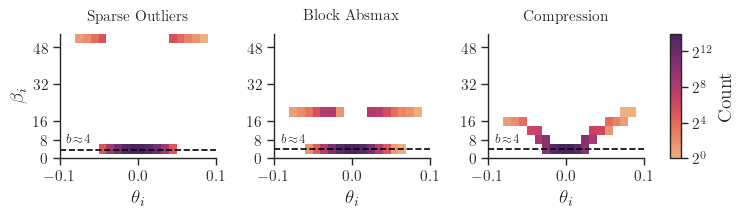

In [14]:
n = 2**16
k = "model.layers.0.mlp.down_proj.weight"

sfmts = [
    ("Sparse Outliers", F.Scaled(3.65, "t", Q.BFLOAT16, (None, None), "rms", "moments", Q.BFLOAT16, 2**-10)),
    ("Block Absmax", F.Scaled(3.8, "t", Q.BFLOAT16, (1, 64), "absmax", "moments", Q.BFLOAT16)),
    ("Compression", F.Scaled(4, "int", Q.BFLOAT16, (None, None), "rms", compressor="optimal")),
]

p = dict(model.model.named_parameters())[k].detach()
figw, figh = matplotlib.rcParams["figure.figsize"]
figure, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[1, 1, 1, 0.07]), figsize=(figw, 0.8*figh))
norm = matplotlib.colors.LogNorm(1, n / 4)
for (title, sfmt), ax in zip(sfmts, axs[:-1]):
    fmt = sfmt.fit(p)
    s = sketch_bits(fmt, p)
    torch.testing.assert_close(tensor(fmt.count_bits_tensor(p) / p.nelement()), s.mean().cpu())

    # ybins = torch.cat([torch.arange(0, 8, 1), torch.arange(8, 16, 2), torch.arange(16, 55, 4)])
    m = ax.hist2d(p.flatten()[:n].float().cpu(), y=s.flatten()[:n].cpu(), cmin=1,
                  bins=(torch.linspace(-0.1, 0.1, 21), torch.arange(2, 55, 4)),
                  cmap=plot_utils.SEQ_PALETTE, norm=norm)
    ax.set_yticks([0, 8, 16, 32, 48])
    ax.set_xlim((-0.1, 0.1))
    ax.set_xticks([-0.1, 0, 0.1])
    ax.set_title(title, pad=10)
    ax.set_xlabel(r"$\theta_i$")
    if ax is axs[0]:
        ax.set_ylabel(r"$\beta_i$")
    ax.axhline(fmt.count_bits_tensor(p) / p.nelement(), color="k", ls="--")
    ax.annotate(r"$b\!\approx\!4$", (-0.1, 4), (5, 3), textcoords="offset points", ha="left", va="bottom", fontsize=9)

cb = figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=plot_utils.SEQ_PALETTE), cax=axs[-1], label="Count")
cbticks = tensor([0, 4, 8, 12])
cb.set_ticks(2**cbticks, labels=[f"$2^{{{i}}}$" for i in cbticks])

plot_utils.tidy(figure)

p = axs[-1].get_position()  # hack
p.x0 -= 0.04
p.x1 -= 0.04
axs[-1].set_position(p)

plot_utils.save("ma_element_bit_histogram")

In [15]:
del model  # memory!